In [1]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Statistics

include("../helpers.jl");
include("../stats.jl");

## Edit before running on new data

In [2]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [3]:
# get data
x_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_df, y_df = readjsonsfromdirectory(target_directory, x_df, y_df);

## Data preprocessing

In [4]:
# decorrelate x_df
function dynamicscale(data_raw, dynamic_lower, upper)
    return (data_raw .- dynamic_lower) ./ (upper .- dynamic_lower)
end

max_dvar_3 = 160
eta_3 = 10.
max_dvar_5 = 1.85
eta_5 = 0.05
max_dvar_12 = 2.0
eta_12 = 0.05
max_dvar_9 = -25.
eta_9 = 2.5
max_dvar_13 = -20.
eta_13 = 2.5

dvar_3_prime = dynamicscale(x_df[:, "DVAR3"], eta_3 .+ x_df[:, "DVAR2"], max_dvar_3)
dvar_5_prime = dynamicscale(x_df[:, "DVAR5"], x_df[:, "DVAR4"] .+ eta_5, max_dvar_5)
dvar_12_prime = dynamicscale(x_df[:, "DVAR12"], x_df[:, "DVAR5"] .+ eta_12, max_dvar_12)
dvar_9_prime = dynamicscale(x_df[:, "DVAR9"], x_df[:, "DVAR8"] .+ eta_9, max_dvar_9)
dvar_13_prime = dynamicscale(x_df[:, "DVAR13"], x_df[:, "DVAR9"] .+ eta_13, max_dvar_13)

x_df[:, "DVAR3"] = dvar_3_prime;
x_df[:, "DVAR5"] = dvar_5_prime;
x_df[:, "DVAR12"] = dvar_12_prime;
x_df[:, "DVAR9"] = dvar_9_prime;
x_df[:, "DVAR13"] = dvar_13_prime;

In [5]:
# scaling data
x_scaled_df = minmaxscaledf(x_df)[1]
y_scaled_df = minmaxscaledf(y_df)[1]

@assert(all(maximum(y_scaled_df[!, colname]) == 1. for colname in names(y_scaled_df)))
@assert(all(minimum(y_scaled_df[!, colname]) == -1. for colname in names(y_scaled_df)))

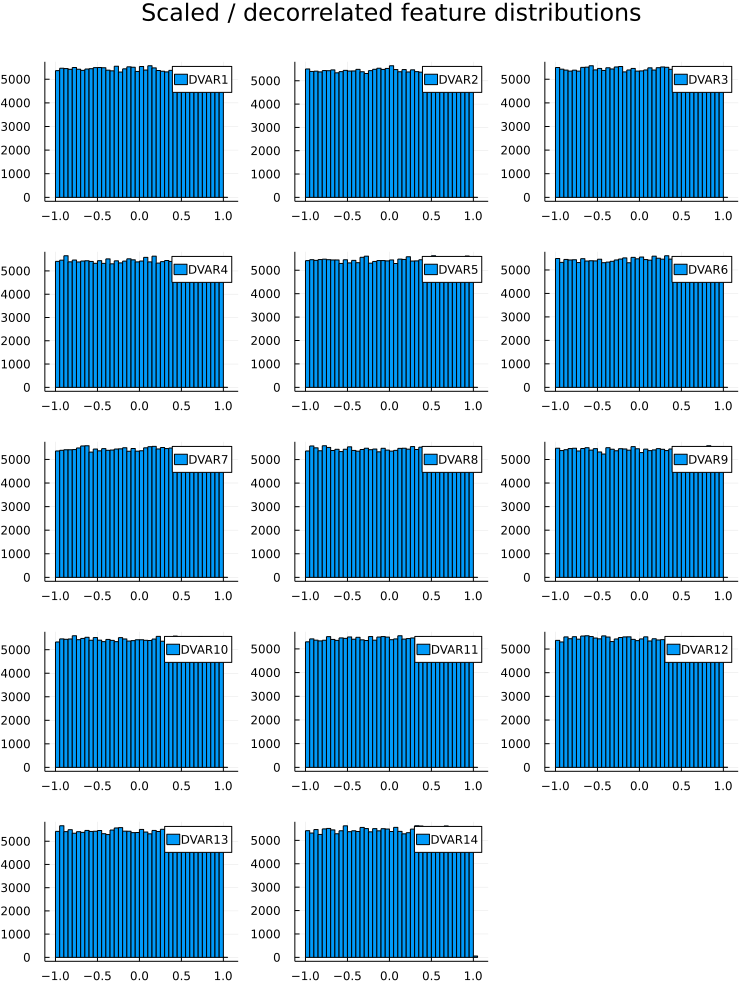

In [6]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_scaled_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Scaled / decorrelated feature distributions")

In [7]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [8]:
# format to arrays
x_train = Float64.(Matrix(x_train_df)); x_test = Float64.(Matrix(x_test_df));
y_train = Float64.(Matrix(y_train_df)); y_test = Float64.(Matrix(y_test_df));

In [9]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

In [10]:
dropout_rate = 0.1

function neuralnetworkwithbatchnorm()
    Chain(
        Dense(x_dimension, 125),
        BatchNorm(125, x->σ.(x)),
        Dense(125, 125),
        BatchNorm(125, x->σ.(x)),
        Dense(125, 125),
        BatchNorm(125, x->σ.(x)),
        Dense(125, 125),
        BatchNorm(125, x->σ.(x)),
        Dense(125, 125),
        BatchNorm(125, x->σ.(x)),
        Dense(125, y_dimension)
    )
end

neuralnetworkwithbatchnorm (generic function with 1 method)

In [11]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [ ]:
# defining our model, optimization algorithm and loss function
m = neuralnetworkwithbatchnorm()
learning_rate = 0.001
optimizer = ADAM(learning_rate)
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 1000
training_losses = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
    
    # learning rate decay, just for fun
    #= 
    if (epoch % 50 == 0) & (epoch < 151)
        learning_rate = learning_rate * 0.1
        optimizer = ADAM(learning_rate)
    end =#
end

epoch 1, loss=3.6603684541445998
epoch 2, loss=2.144439711797693
epoch 3, loss=1.9373754137266965
epoch 4, loss=1.8076535402294167
epoch 5, loss=1.65856486237656
epoch 6, loss=1.5077494814443053
epoch 7, loss=1.586130986408739
epoch 8, loss=1.5310353876058347
epoch 9, loss=1.3389647631016768
epoch 10, loss=1.2941193888482396
epoch 11, loss=1.2710980423052385
epoch 12, loss=1.2285033907031184
epoch 13, loss=1.1655576390317157
epoch 14, loss=1.231036217984355
epoch 15, loss=1.2011686448346164
epoch 16, loss=1.1676181009002382
epoch 17, loss=1.1374014928827685
epoch 18, loss=1.1034853872773362
epoch 19, loss=1.1720871812106535
epoch 20, loss=1.1332797596926485
epoch 21, loss=1.0717929654666476
epoch 22, loss=1.1116091465663258
epoch 23, loss=1.1022271916966386
epoch 24, loss=1.08057514642393
epoch 25, loss=1.1379281103171721
epoch 26, loss=1.0624293776775835
epoch 27, loss=1.1122785865249833
epoch 28, loss=1.1016739724552669
epoch 29, loss=1.082185053950379
epoch 30, loss=1.08811068436087

epoch 239, loss=0.8815686820510453
epoch 240, loss=0.8684340385689747
epoch 241, loss=0.8939746123617607
epoch 242, loss=0.8659840832126338
epoch 243, loss=0.8466744144048197
epoch 244, loss=0.8853207582848776
epoch 245, loss=0.8483726714886387
epoch 246, loss=0.9174132253381532
epoch 247, loss=0.8742855397229938
epoch 248, loss=0.8529589067335894
epoch 249, loss=0.94025762588716
epoch 250, loss=0.8285007923231813
epoch 251, loss=0.8336819558405109
epoch 252, loss=0.8494349791668
epoch 253, loss=0.9019978480610651
epoch 254, loss=0.8496637978516028
epoch 255, loss=0.8581779681329534
epoch 256, loss=0.8376013163260626
epoch 257, loss=0.966363210852614
epoch 258, loss=0.8463300768767557
epoch 259, loss=0.8392944139526904
epoch 260, loss=0.8424298494025039
epoch 261, loss=0.882409703756181
epoch 262, loss=0.8486991344711239
epoch 263, loss=0.8340239071874105
epoch 264, loss=0.865321510229652
epoch 265, loss=0.838933399532643
epoch 266, loss=0.8513356768290725
epoch 267, loss=0.84957424193

epoch 474, loss=0.804910292493842
epoch 475, loss=0.9198667536321252
epoch 476, loss=0.8162528729553411
epoch 477, loss=0.8059535546556212
epoch 478, loss=0.8031547746782053
epoch 479, loss=0.7967803545239963
epoch 480, loss=0.8027051587665842
epoch 481, loss=0.8477449166927489
epoch 482, loss=0.7934181776128832
epoch 483, loss=0.8013798015942487
epoch 484, loss=0.8030875682988496
epoch 485, loss=0.8065880923847218
epoch 486, loss=0.8230641979420462
epoch 487, loss=0.8062013898796186
epoch 488, loss=0.8251829541410038
epoch 489, loss=0.7934472952758532
epoch 490, loss=0.7939698954520128
epoch 491, loss=0.7794515986987942
epoch 492, loss=0.8138765681993008
epoch 493, loss=0.8516277263529409
epoch 494, loss=0.8077416303952603
epoch 495, loss=0.8275426851166882
epoch 496, loss=0.8247770666375149
epoch 497, loss=0.7973921895418897
epoch 498, loss=0.8464636216223408
epoch 499, loss=0.837034100352059
epoch 500, loss=0.8503290509909157
epoch 501, loss=0.7897214371411869
epoch 502, loss=0.8271

epoch 709, loss=0.793732780037525
epoch 710, loss=0.7533232879062074
epoch 711, loss=0.7993848545929848
epoch 712, loss=0.7541112780129637
epoch 713, loss=0.786503035947014
epoch 714, loss=0.7466250743058751
epoch 715, loss=0.7392236692280029
epoch 716, loss=0.74389180055569
epoch 717, loss=0.8029905050035824
epoch 718, loss=0.7708412935326169
epoch 719, loss=0.744671192267272
epoch 720, loss=0.7480512349549537
epoch 721, loss=0.7761790933860526
epoch 722, loss=0.7399830590721942
epoch 723, loss=0.7590436810715826
epoch 724, loss=0.8309682255216353
epoch 725, loss=0.7578563140330087
epoch 726, loss=0.7436867886277341
epoch 727, loss=0.7570335032517689
epoch 728, loss=0.776589287854714
epoch 729, loss=0.7552473356087566
epoch 730, loss=0.7616912813933081
epoch 731, loss=0.768171686706528
epoch 732, loss=0.7328043429400517
epoch 733, loss=0.7692117141536134
epoch 734, loss=0.7354909423189018
epoch 735, loss=0.7482869138522115
epoch 736, loss=0.7371385414129139
epoch 737, loss=0.848317664

In [ ]:
# plot training history
plot(epochs, training_losses;
    title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false,
    label="w5, d200, dropout_rate=$dropout_rate", dpi=400,
    grid=false, xtickfontsize=10, ytickfontsize=10, legendfontsize=10, yaxis=:log)

## Model evaluation

In [ ]:
y_train_preds = m(x_train')';
y_test_preds = m(x_test')';

In [ ]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

In [ ]:
r2_train = r2score_multidim(y_train, y_train_preds)
r2_test = r2score_multidim(y_test, y_test_preds)
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

In [ ]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

In [ ]:
adjustedr2_train = adjustedr2score_multidim(y_train, y_train_preds, size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, y_test_preds, size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

In [ ]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

println("MAPEs on test sets")
for i in 1:y_dimension
    temp_train_trues_normalized = y_train[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_test_preds_normalized = y_test_preds[:, i]
    
    # unnormalize
    y_scaler = MinMaxScaler(0., 0.)
    fit!(y_scaler, y_df[!, "OBJ$i"])
    
    temp_train_trues_original = inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_trues_original = inverse_transform(y_scaler, temp_test_trues_normalized)
    temp_train_preds_original = inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_test_preds_original = inverse_transform(y_scaler, temp_test_preds_normalized)
    
    println(
        "OBJ$i: ",
        mape(temp_test_preds_original, temp_test_trues_original)
    )
end

In [ ]:
i = 8
println("true: ", y_test[i, :])
println("predicted: ", y_test_preds[i, :])